In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.models import Sequential
import tensorflow as tf
import tensorflow_datasets as tfds

from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import cv2
import random
from numpy import *
from PIL import Image
import glob
import seaborn as sns
import pandas as pd

from imblearn.over_sampling import RandomOverSampler

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization,Embedding
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ReLU, LSTM,Bidirectional,Attention,Concatenate
from tensorflow.keras import regularizers, optimizers,losses
from tensorflow.keras.metrics import Recall,Precision,AUC,TruePositives,TrueNegatives,FalseNegatives,FalsePositives, SpecificityAtSensitivity,SensitivityAtSpecificity
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.utils import np_utils

In [4]:
!cp -r "/content/drive/MyDrive/HAM_FIN" "/content/dataset"
directory_path = "/content/dataset"

In [9]:
meta_data = pd.read_csv('/content/drive/MyDrive/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [10]:
classes = {0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           1: ('bcc', 'basal cell carcinoma'),
           2: ('bkl', 'benign keratosis-like lesions'),
           3: ('df', 'dermatofibroma'),
           4: ('mel', 'melanoma'),
           5: ('nv', 'melanocytic nevi'),
           6: ('vasc', 'pyogenic granulomas and hemorrhage')}

CATEGORIES = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
IMG_SIZE = 224
num_class=len(CATEGORIES)

In [26]:
batch_size = 64
img_size = (224, 224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Optimize performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 10080 files belonging to 7 classes.
Using 8064 files for training.
Found 10080 files belonging to 7 classes.
Using 2016 files for validation.


Text(0.5, 1.0, 'Frequency Distribution of Classes')

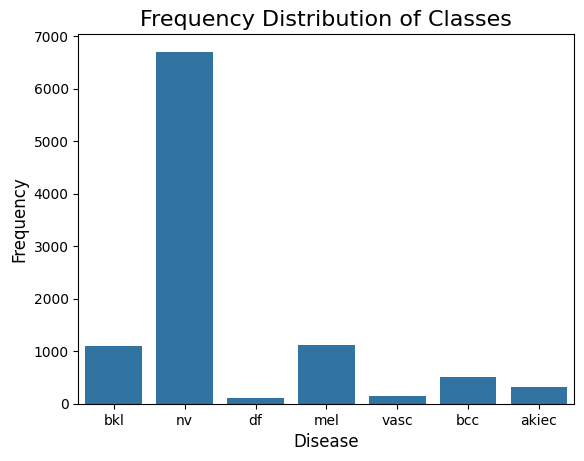

In [ ]:
sns.countplot(x = 'dx', data = meta_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

Text(0.5, 1.0, 'Gender of Patient')

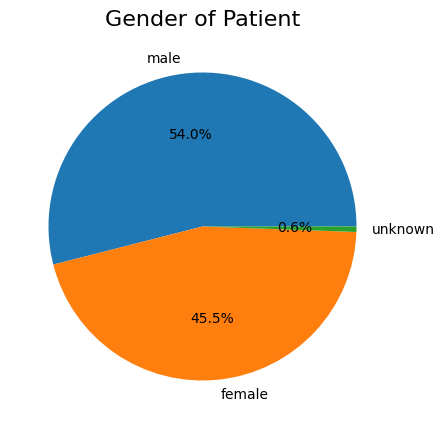

In [ ]:
bar, ax = plt.subplots(figsize = (5,5))
plt.pie(meta_data['sex'].value_counts(), labels = meta_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

Text(0.5, 1.0, 'Histogram of Age of Patients')

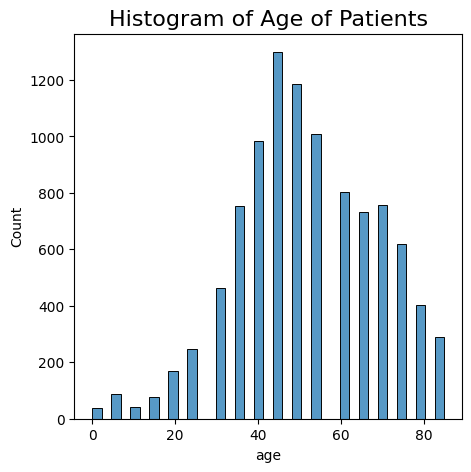

In [ ]:
bar, ax = plt.subplots(figsize=(5,5))
sns.histplot(meta_data['age'])
plt.title('Histogram of Age of Patients', size=16)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

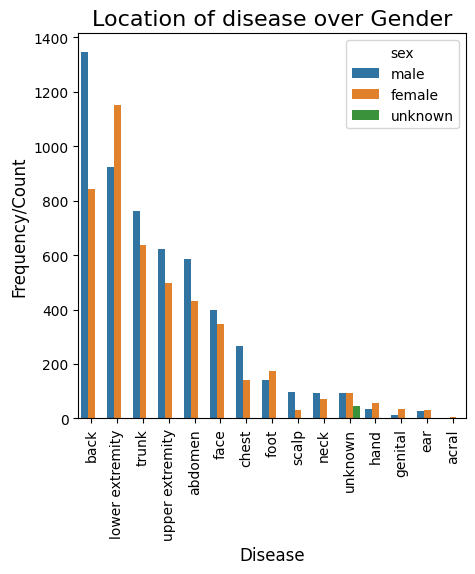

In [ ]:
value = meta_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (5, 5))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

In [27]:
def preprocess_data(images, labels):
  labels = tf.one_hot(labels, depth=num_class)
  return images, labels

# Apply preprocessing to train_ds and val_ds
train_ds = train_ds.map(preprocess_data)
val_ds = val_ds.map(preprocess_data)

In [28]:
train_ds = train_ds.map(lambda x, y: (x, y), num_parallel_calls=AUTOTUNE)

In [29]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def create_vit_classifier(
    input_shape = (224, 224, 3),
    patch_size = 28 ,
    num_patches = 64 ,
    projection_dim = 64,
    num_heads = 8,
    transformer_layers=12,
    mlp_head_units=[4096, 2048],
    num_classes = 7

):
    inputs = layers.Input(shape=input_shape)

    # Patch embedding
    patches = layers.Conv2D(projection_dim, kernel_size=patch_size, strides=patch_size, padding="VALID")(inputs)
    patches = layers.Reshape((num_patches, projection_dim))(patches)

    # Position embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    encoded_patches = patches + position_embedding

    # Transformer blocks
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=[projection_dim * 2, projection_dim], dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    # MLP head
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation,
    hidden_units=mlp_head_units, dropout_rate=0.5)

    logits = layers.Dense(num_classes)(features)
    outputs = layers.Activation("softmax")(logits)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create the ViT model
model = create_vit_classifier()

# Print model summary
print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_1 (Cast)             │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 64)       │        150,592 │ cast_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 64, 64)         │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_50 (Add)              │ (None, 64, 64)         │              0 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_50    │ (None, 64, 64)         │            128 │ add_50[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_24   │ (None, 64, 64)         │        132,672 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_51 (Add)              │ (None, 64, 64)         │              0 │ multi_head_attention_… │
│                           │                        │                │ add_50[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_51    │ (None, 64, 64)         │            128 │ add_51[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_54 (Dense)          │ (None, 64, 128)        │          8,320 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_79 (Dropout)      │ (None, 64, 128)        │              0 │ dense_54[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_55 (Dense)          │ (None, 64, 64)         │          8,256 │ dropout_79[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_80 (Dropout)      │ (None, 64, 64)         │              0 │ dense_55[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_52 (Add)              │ (None, 64, 64)         │              0 │ dropout_80[0][0],      │
│                           │                        │                │ add_51[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_52    │ (None, 64, 64)         │            128 │ add_52[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_25   │ (None, 64, 64)         │        132,672 │ layer_normalization_5… │
│ (MultiHeadAttention) 

 Total params: 27,131,079 (103.50 MB)

 Trainable params: 27,131,079 (103.50 MB)

 Non-trainable params: 0 (0.00 B)

None


In [30]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ModelCheckpoint untuk menyimpan model terbaik
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',  # Sesuaikan jika val_accuracy menggunakan nama lain seperti 'val_accuracy'
    mode='max',
    verbose=1
)

# EarlyStopping untuk menghentikan pelatihan jika val_accuracy mencapai 95%
callback_early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Sesuaikan jika nama metrik berbeda
    patience=10,  # Jumlah epoch sebelum berhenti jika kondisi tidak membaik
    mode='max',
    verbose=1,
    baseline=0.95,  # Syarat val_accuracy minimal 95%
    restore_best_weights=True  # Mengembalikan bobot terbaik
)

# Gabungkan kedua callback
callbacks = [callback_checkpoint, callback_early_stopping]

In [32]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy',Recall(), Precision(), AUC(),
           TruePositives(), TrueNegatives(), FalseNegatives(), FalsePositives()]
)

# Latih model
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=(val_ds),
    batch_size=64,
    #callbacks=callbacks  # Perbaikan: Menggunakan 'callbacks' bukan 'callback'
)

Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1444 - auc_2: 0.4975 - false_negatives_2: 3837.9365 - false_positives_2: 1429.4841 - loss: 3.0975 - precision_2: 0.1344 - recall_2: 0.0648 - true_negatives_2: 22954.5156 - true_positives_2: 226.0635
Epoch 1: saving model to best_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 1068s 8s/step - accuracy: 0.1444 - auc_2: 0.4975 - false_negatives_2: 3868.6851 - false_positives_2: 1433.8031 - loss: 3.0937 - precision_2: 0.1344 - recall_2: 0.0646 - true_negatives_2: 23139.1738 - true_positives_2: 226.8110 - val_accuracy: 0.1359 - val_auc_2: 0.5320 - val_false_negatives_2: 2016.0000 - val_false_positives_2: 0.0000e+00 - val_loss: 1.9654 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_true_negatives_2: 12096.0000 - val_true_positives_2: 0.0000e+00
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.1466 - auc_2: 0.5027 - false_negatives_2: 4041.4761 - false_positives_2: 105.0635 - loss: 2.1432 - precision

In [33]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=(val_ds),
    batch_size=64,
    #callbacks=callbacks  # Perbaikan: Menggunakan 'callbacks' bukan 'callback'
)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 57s 448ms/step - accuracy: 0.3576 - auc_2: 0.7853 - false_negatives_2: 3534.7717 - false_positives_2: 419.3858 - loss: 1.5431 - precision_2: 0.5761 - recall_2: 0.1329 - true_negatives_2: 24153.5898 - true_positives_2: 560.7244 - val_accuracy: 0.4157 - val_auc_2: 0.8165 - val_false_negatives_2: 1645.0000 - val_false_positives_2: 254.0000 - val_loss: 1.4464 - val_precision_2: 0.5936 - val_recall_2: 0.1840 - val_true_negatives_2: 11842.0000 - val_true_positives_2: 371.0000
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 503ms/step - accuracy: 0.3914 - auc_2: 0.7964 - false_negatives_2: 3474.2126 - false_positives_2: 441.4016 - loss: 1.5079 - precision_2: 0.5810 - recall_2: 0.1505 - true_negatives_2: 24131.5742 - true_positives_2: 621.2834 - val_accuracy: 0.4226 - val_auc_2: 0.8399 - val_false_negatives_2: 1699.0000 - val_false_positives_2: 117.0000 - val_loss: 1.3509 - val_precision_2: 0.7304 - val_recall_2: 0.1572 - val_true_negatives_2: 11979.0000 - v

In [34]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=(val_ds),
    batch_size=64,
    #callbacks=callbacks  # Perbaikan: Menggunakan 'callbacks' bukan 'callback'
)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 426ms/step - accuracy: 0.7986 - auc_2: 0.9745 - false_negatives_2: 1108.8661 - false_positives_2: 525.7166 - loss: 0.5443 - precision_2: 0.8561 - recall_2: 0.7357 - true_negatives_2: 24047.2598 - true_positives_2: 2986.6299 - val_accuracy: 0.6166 - val_auc_2: 0.9138 - val_false_negatives_2: 916.0000 - val_false_positives_2: 507.0000 - val_loss: 1.0813 - val_precision_2: 0.6845 - val_recall_2: 0.5456 - val_true_negatives_2: 11589.0000 - val_true_positives_2: 1100.0000
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 91s 498ms/step - accuracy: 0.8080 - auc_2: 0.9756 - false_negatives_2: 1048.6378 - false_positives_2: 524.6536 - loss: 0.5330 - precision_2: 0.8588 - recall_2: 0.7529 - true_negatives_2: 24048.3223 - true_positives_2: 3046.8582 - val_accuracy: 0.6195 - val_auc_2: 0.9146 - val_false_negatives_2: 894.0000 - val_false_positives_2: 542.0000 - val_loss: 1.0877 - val_precision_2: 0.6743 - val_recall_2: 0.5565 - val_true_negatives_2: 11554.0000 - 

KeyboardInterrupt: 

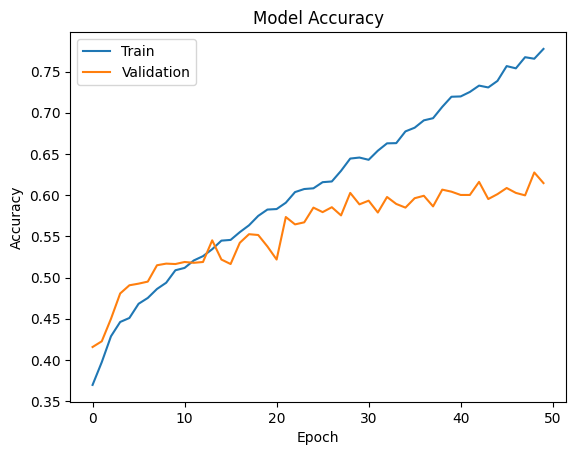

In [35]:
import matplotlib.pyplot as plt

# Gunakan 'accuracy' dan 'val_accuracy' sebagai kunci
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

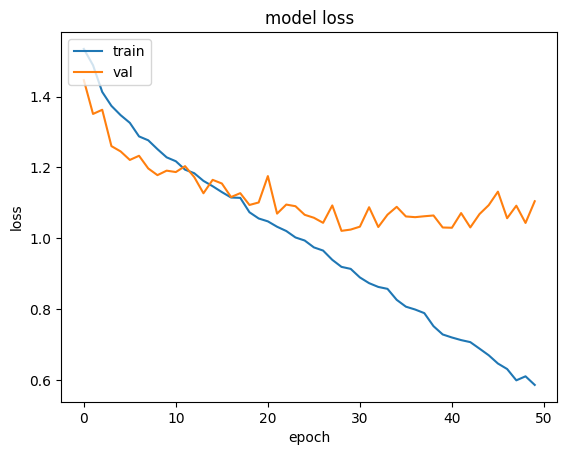

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()